$\newcommand{\x}[1]{\textbf{x}_{#1}}$
$\newcommand{\alp}[1]{\alpha_{#1}}$
$\newcommand{\alphat}[1]{\bar{\alpha}_{#1}}$
$\newcommand{\sqrtalpha}[1]{\sqrt{\alpha_{#1}}}$
$\newcommand{\sqrtalphahat}[1]{\sqrt{\bar{\alpha}_{#1}}}$
$\newcommand{\xhat}[1]{\hat{\textbf{\textit{x}}}_{#1}}$
$\newcommand{\bmu}[1]{\mathbf{\mu}_{#1}}$
$\newcommand{\bSigma}[1]{\mathbf{\Sigma}_{#1}}$

In [1]:
from torch.utils.data import DataLoader, random_split
import torch

torch.manual_seed(42)

from utils import CelebA

data = CelebA(n = 2000, size = 32)

split_fracs = [0.8, 0.15, 0.05]
train_set, test_set, val_set = random_split(data, split_fracs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dimensions = train_set[0].shape
img_size = torch.prod(torch.tensor(dimensions))

Files already downloaded and verified


## The data
First, let's have a look at our data. Our data will conist of images and will therefore have the dimensions (channels, height, width).<br>
These pictures are our "ground-truth", and we'll denote them as $\mathbf{\textit{x}}_0$. <br>
It is these pictures that we gradually will make more and more noisy in order to train our model.

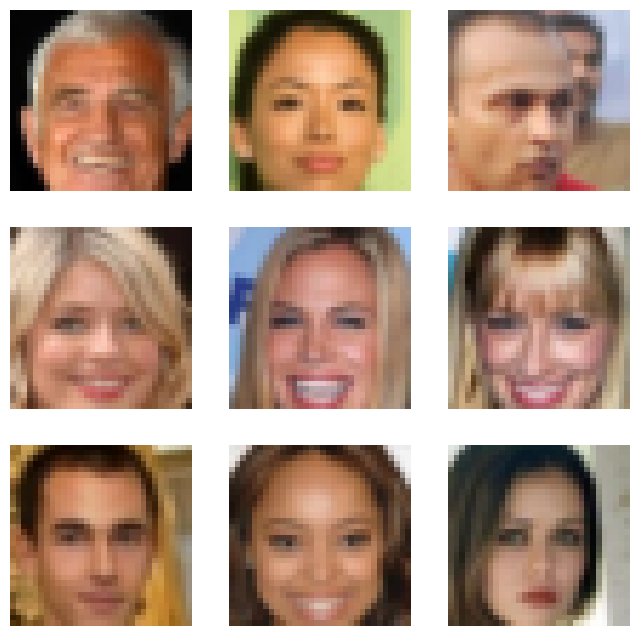

In [2]:
## Visualize the data
import matplotlib.pyplot as plt
import numpy as np

# show multiple images in a 
# grid format
fig, axs = plt.subplots(3, 3, figsize=(8,8))
for i in range(9):
    img = train_set[i]
    img = img * 0.5 + 0.5
    axs[i//3, i%3].imshow(img.view(*dimensions).permute(1,2,0), cmap='gray')
    axs[i//3, i%3].axis('off')


## Noise schedule
The noise schedule is defined as: <br>
$\begin{equation}
q(\x{t}|\x{t-1}) = \mathcal{N}(\x{t};\sqrt{1-\beta_t}\x{t-1},\beta_t \mathbf{I})
\end{equation}$
Where $\beta_t$ are linear interpolations on the range from $\beta_{0}$ to $\beta_{T}$. Typically, the noise schedule will be in the range from $\beta_0=0.001$ to $\beta_T = 0.02$. <br>
#### The noise schedule describes what distribution each pixel value should follow in the next noisy image based on the prior slightly less noisy image.<br>
If we let $\alpha_t$ = $1-\beta_t$, it can be shown that some arbitrary timestep, $t$, will follow this distribution: <br>
$\begin{equation}
 q(\x{t}|\x{0}) = \mathcal{N}(\x{t}, \sqrt{\bar{\alpha}_t}\x{0}, (1-\bar{\alpha}_t) \mathbf{I})
\end{equation}$
Where $\bar{\alpha}_t = \prod_{t=1}^T \alpha_t$.<br>
The Markov-chain also assures us that it doesnt matter whether we condition of $\x{0}$ or $\x{t-1}$, since $\x{t-1}$ only depends on $\x{0}$ anyways. <br>
Using the reparameteriation trick, a sample can be drawn by calculating:
$\begin{equation}
\x{t} = \sqrtalphahat{t}\x{0} +\sqrt{1-\alphat{t}}\epsilon^* \hspace{10mm} \epsilon^* \sim \mathcal{N}(\mathbf{0},\mathbf{1})
\end{equation}$
#### Using this fact, we can take some $\x{0}$, randomly sample some timesteps, $t \in [1, T]$, find the pertaining distributions for the noisy images and draw a sample from this distribution:

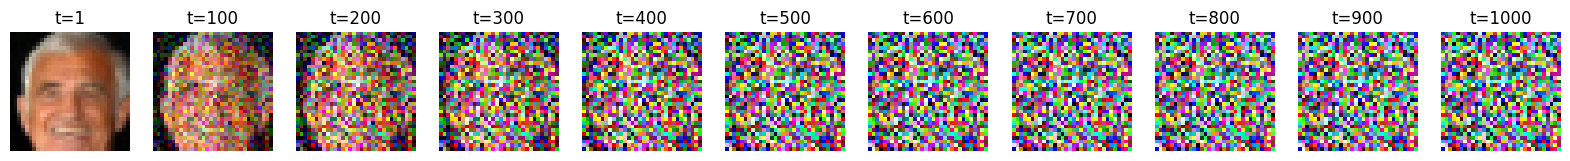

In [3]:
## make noisy images

from utils import NoiseSchedule

beta_start = 1e-4
beta_end = 0.02
T = 1000
noise_schedule = NoiseSchedule(beta_start, beta_end, T)

fig, axs = plt.subplots(1, 11, figsize=(20, 2))
x0 = train_set[0].flatten()
ts = torch.linspace(0, T - 1, 11).view(-1, 1).long()
xts, _, _ = noise_schedule.make_noisy_images(x0, ts)
for i, t in enumerate(ts):
    img = xts[i].view(*dimensions).permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f't={t.item() + 1}')
plt.savefig("figures/noisy_images.png", dpi=300, bbox_inches='tight')
plt.show()


# Examining the distribution

A better way of understanding the noise scheduling is to examine what happens to the value of a single pixel. <br>
As seen below, the value of the pixel is approching 0 and the standard deviation is approaching 1. In other words, the pixel is becoming closer to a standard normal distribution. This is the goal of the noise scheduling. <br>
However, the distribution only approaches the standard normal distribution, it does not reach it. This is because the noise is not added to the pixel, but rather multiplied by the pixel. This means that the pixel will never reach 0, but rather approach it. The values of $\mu$ and $\sigma$ for each pixel distribution are shown below.

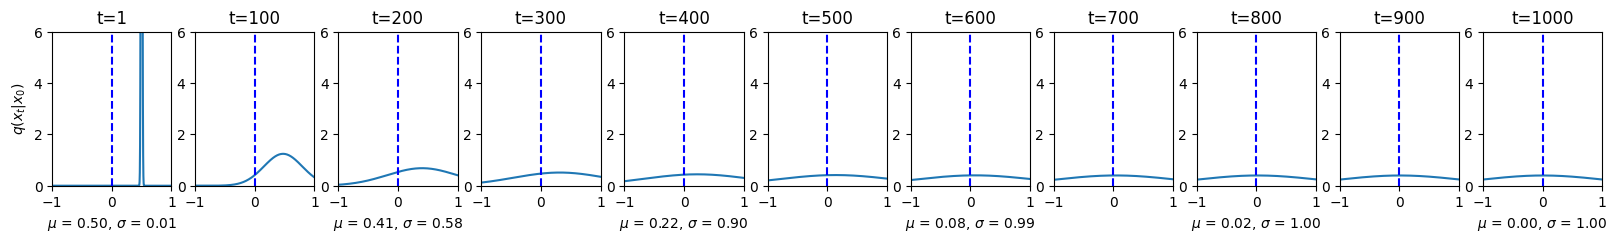

In [4]:
def normal_dist(x, mu, std):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * std**2))
pixel_value = 0.5
fig, axs = plt.subplots(1, 11, figsize=(20, 2))
mus = noise_schedule.sqrt_alpha_hat[ts]
stds = noise_schedule.sqrt_one_minus_alpha_hat[ts]
xx = torch.linspace(-2, 2, 1000)
for i, t in enumerate(ts):
    mu = mus[i] * pixel_value
    std = stds[i]
    axs[i].plot(xx, normal_dist(xx, mu, std))
    axs[i].set_title(f't={t.item() + 1}')
    axs[i].set_ylim(0, 6)
    axs[i].set_xlim(-1, 1)
    axs[i].axvline(0, color='b', linestyle='--')
    if i % 2 == 0:
        axs[i].set_xlabel("$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(round(mu.item(), 2), round(std.item(), 2)))
    if i == 0:
        axs[i].set_ylabel('$q(x_t | x_0)$')

plt.savefig("figures/pixel_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# The distribution of $p(\x{T})$
To show that the distribution of the final layer ($p(\x{T})$) actually approaches a standard normal distribution, we've plotted the KL-divergence between each layer and a standard normal. The KL-divergence clearly approaches 0. 

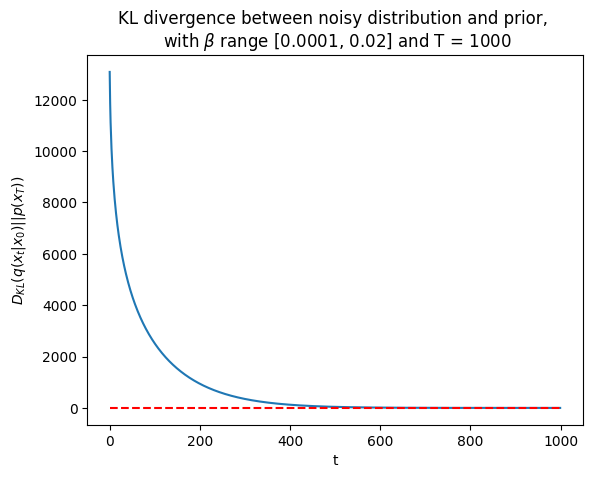

In [5]:
from tqdm import tqdm

## this small image is just a 10x10 patch of the original image

KL_list = np.zeros(T)
for t in range(T):
    mu = noise_schedule.sqrt_alpha_hat[t] * x0.flatten()
    std = noise_schedule.sqrt_one_minus_alpha_hat[t]

    k1 = img_size * std ** 2
    k2 = torch.sum(mu ** 2)
    k3 = - 2 * img_size * torch.log(std)
    kl = 1/2 * (k1 + k2 + k3 - img_size)
    
    KL_list[t] = kl.detach().numpy()

plt.plot(KL_list)
txt = "KL divergence between noisy distribution and prior, \n with " + r"$\beta$" + " range [0.0001, 0.02] and T = {}"
plt.title(txt.format(T))
plt.xlabel("t")
plt.ylabel("$D_{KL}(q(x_t | x_0) || p(x_T))$")
plt.hlines(0, 0, T, color='r', linestyle='--')
plt.savefig("figures/KL_divergence.png", dpi=300, bbox_inches='tight')
plt.show()


## Encoding the timesteps
It can be shown, that in order to train a diffusion model, the following loss function can be used:
$\begin{equation}
\mathcal{L}_{simple} = ||\epsilon^*-\mathbf{\hat{\epsilon}_{\theta}}(\x{t},t)||_2^2
\end{equation}$
Where $\epsilon^*$ is the noise used to sample $\x{t}$ from $\x{0}$, and where $\hat{\epsilon}_{\theta}$ is our models best guess at this noise. <br>
Since we're making one model for all timesteps, it could be beneficial to somehow tell the model which timestep it is in (notice that $t$ is also an input to the model). There are different approaches to this: deterministic timeembeddings and learnable timeembeddings. <br>
We decided to go with deterministic, sinusoidal encoding. This means that every $t$ gets mapped to a unique $sin$ and $cos$ wave as visualized below using a heat map:

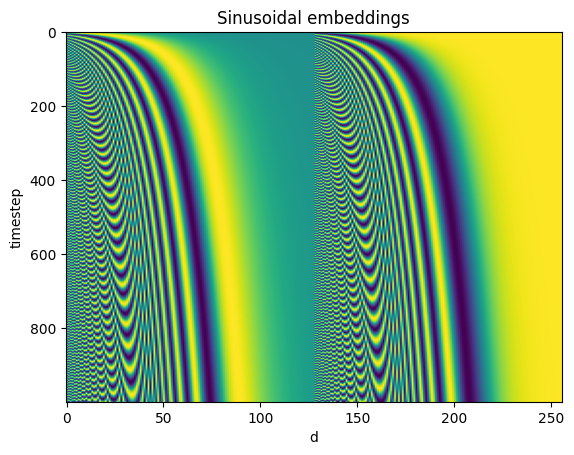

In [6]:
from utils import SinusoidalEmbeddings

ts = np.arange(0, T)
embeddings = SinusoidalEmbeddings(torch.tensor(ts).float())
plt.imshow(embeddings, cmap='viridis', aspect='auto')
plt.ylabel("timestep")
plt.xlabel("d")
plt.title("Sinusoidal embeddings")
plt.savefig("figures/sinusoidal_embeddings.png", dpi=300, bbox_inches='tight')
plt.show()


## The model
The model is a simple residual UNet using convolutions. <br>
The simple loss, $\mathcal{L}_{simple}$, can be summarised as:
   
1. **Repeat until convergence:**
   - $\x{0} \sim q(\x{0})$
   - $t \sim \text{Uniform}(1,\dots,T)$
   - $\epsilon^* \sim \mathcal{N}(\mathbf{0},\mathbf{1})$
   - $\x{t} \gets \sqrtalphahat{t}\x{0} + \sqrt{1-\alphat{t}}\epsilon^*$
   - Take a gradient descent step on $\nabla_{\theta}||\epsilon^*-\mathbf{\hat{\epsilon}_{\theta}}(\x{t},t)||_2^2$

The loss function can be found inside the model class.<br>
For now, we'll train very small models with few parameters since we want to examine the behaviour of the model later. <br>
Later on, we'll train a bigger model.

In [7]:
from utils import SimpleModel
from model import UNetModel
import torch.nn as nn
mse = nn.MSELoss()

network_args = {
    "in_channels": dimensions[0], 
    "model_channels": 64, 
    "out_channels": dimensions[0], 
    "num_res_blocks": 2, 
    "attention_resolutions": [2], 
    "dropout": 0.1,
    "num_heads": 8,
    "num_heads_upsample": 8,
}

simple_network = UNetModel(**network_args)

model_args = [simple_network, noise_schedule, dimensions, device]
simple_model = SimpleModel(*model_args)
simple_model.load_model()
num_params = sum(p.numel() for p in simple_model.parameters() if p.requires_grad)
print("Number of parameters: ", num_params)

Model loaded from ../models/simple_model.pt
Number of parameters:  56906115


## Visualizing performance
It could be a good idea to see how well our model is performing after each epoch. Of course, we'll look at the loss, but we'll also take a look at how well the model can sample new images.
The sample process can be described as:
1. **Initialize:**
   - $\x{T} \sim \mathcal{N}(\mathbf{0},\mathbf{1})$ 

2. **For $t$ from $T$ down to $1$ do the following:**
   - $\x{t-1} \gets \frac{1}{\sqrtalpha{t}}\x{t}-\frac{1-\alp{t}}{\sqrt{1-\alphat{t}}\sqrtalpha{t}}\mathbf{\hat{\epsilon}_{\theta}}(\x{t},t)$
   
   - **If $t > 0$:**
     - $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{1})$
     - $\x{t-1} \gets \x{t-1} + \mathbf{z}\sigma_q(t)$

3. **Return:**
   - $x_0$

The code for finding the prior sample (finding $\x{t-1}$ from $\x{t}$) can be found in the model class.



In [8]:
from utils import training_loop

In [9]:
simple_model_losses, simple_model_parameters = training_loop(simple_model, 20, train_set, val_set, batch_size=64, save_params=True)
torch.save(simple_model_parameters, "../data/simple_model_parameters.pt")
torch.save(simple_model_losses, "../data/simple_model_losses.pt")

100%|██████████| 25/25 [00:40<00:00,  1.64s/it]


Model saved to ../models/simple_model.pt
Epoch: 0
Train loss: 0.03683701902627945
Validation loss: 0.03328940272331238


100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Model saved to ../models/simple_model.pt
Epoch: 1
Train loss: 0.030375462025403976
Validation loss: 0.02878323197364807


100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


Model saved to ../models/simple_model.pt
Epoch: 2
Train loss: 0.028675084933638573
Validation loss: 0.021953418850898743


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Model saved to ../models/simple_model.pt
Epoch: 3
Train loss: 0.029905639588832855
Validation loss: 0.0307198166847229


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Model saved to ../models/simple_model.pt
Epoch: 4
Train loss: 0.02544650249183178
Validation loss: 0.028091823682188988


100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


Model saved to ../models/simple_model.pt
Epoch: 5
Train loss: 0.02575877122581005
Validation loss: 0.023056190460920334


100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Model saved to ../models/simple_model.pt
Epoch: 6
Train loss: 0.03197822719812393
Validation loss: 0.019789373502135277


100%|██████████| 25/25 [00:36<00:00,  1.48s/it]


Model saved to ../models/simple_model.pt
Epoch: 7
Train loss: 0.028655625879764557
Validation loss: 0.031922996044158936


100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Model saved to ../models/simple_model.pt
Epoch: 8
Train loss: 0.028636720031499863
Validation loss: 0.027339648455381393


100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


Model saved to ../models/simple_model.pt
Epoch: 9
Train loss: 0.026640407741069794
Validation loss: 0.014259818941354752


100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Model saved to ../models/simple_model.pt
Epoch: 10
Train loss: 0.026042340323328972
Validation loss: 0.022537872195243835


100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Model saved to ../models/simple_model.pt
Epoch: 11
Train loss: 0.026471104472875595
Validation loss: 0.019553303718566895


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Model saved to ../models/simple_model.pt
Epoch: 12
Train loss: 0.02787717804312706
Validation loss: 0.0236275102943182


100%|██████████| 25/25 [00:41<00:00,  1.64s/it]


Model saved to ../models/simple_model.pt
Epoch: 13
Train loss: 0.025937221944332123
Validation loss: 0.021882154047489166


100%|██████████| 25/25 [00:41<00:00,  1.65s/it]


Model saved to ../models/simple_model.pt
Epoch: 14
Train loss: 0.027608010917901993
Validation loss: 0.028109317645430565


100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Model saved to ../models/simple_model.pt
Epoch: 15
Train loss: 0.026703281328082085
Validation loss: 0.029616771265864372


100%|██████████| 25/25 [00:33<00:00,  1.32s/it]


Model saved to ../models/simple_model.pt
Epoch: 16
Train loss: 0.02991015650331974
Validation loss: 0.02612086944282055


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


Model saved to ../models/simple_model.pt
Epoch: 17
Train loss: 0.026295796036720276
Validation loss: 0.025909345597028732


100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


Model saved to ../models/simple_model.pt
Epoch: 18
Train loss: 0.028733789920806885
Validation loss: 0.030744660645723343


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


Model saved to ../models/simple_model.pt
Epoch: 19
Train loss: 0.025617677718400955
Validation loss: 0.03437226265668869


In [24]:
from utils import sample_approved_grid, sample_grid, sample_intermediate_images, show_losses

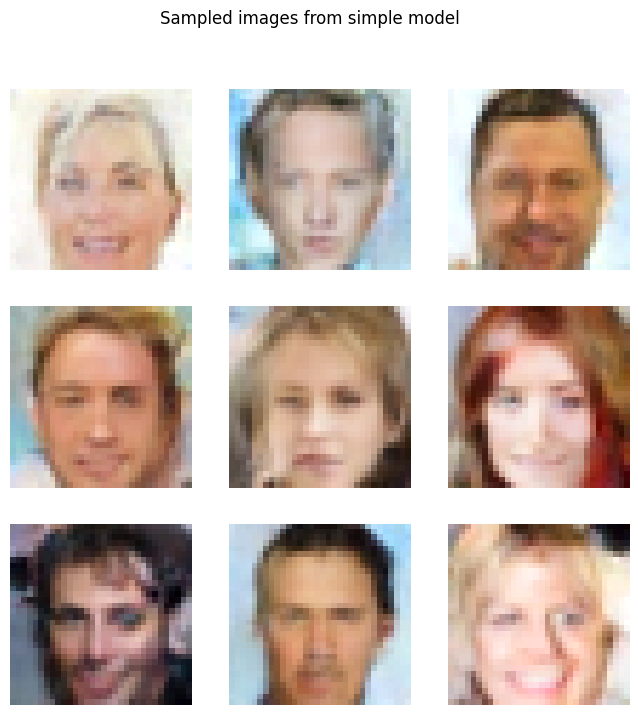

Sampling image..


1000it [00:24, 40.09it/s]                        


Done sampling image


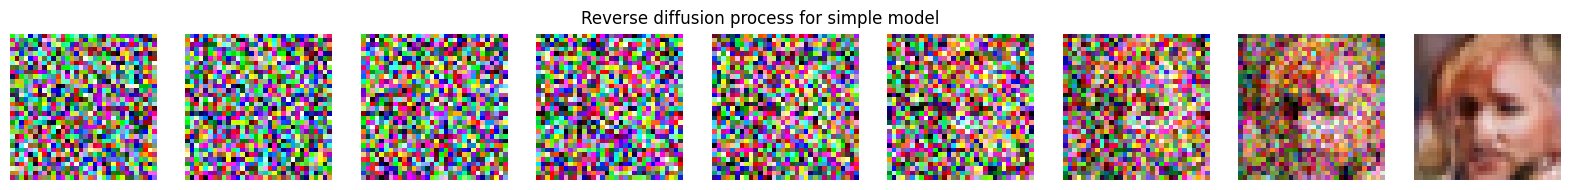

In [25]:
show_losses(simple_model_losses[4:])
sample_approved_grid(simple_model, title="Sampled images from simple model")
sample_intermediate_images(simple_model, title="Reverse diffusion process for simple model")

## Another type of model
We will repeat the above, but for another type of loss function. 
This loss function doesnt predict the noise, $\epsilon^*$, but rather the original image, $\x{0}$. <br>
We wont go into too many details around how this model works, but we'll later try to compare the performance of the different models.

In [9]:
from utils import x0Model

torch.cuda.empty_cache()

x0_network = UNetModel(**network_args)

model_args = [x0_network, noise_schedule, dimensions, device]
x0_model = x0Model(*model_args)
x0_model.load_model()

Failed to load model from ../models/x0_model.pt
Initializing new model


In [ ]:
x0_model_losses, x0_model_parameters = training_loop(x0_model, 20, train_set, val_set, test_set)
np.save("../data/mu_model_losses.npy", x0_model_losses)
np.save("../data/mu_model_parameters.npy", x0_model_parameters)

In [ ]:
def error_per_timestep(model, dataset):
    n = 1
    model.eval()
    x0s = dataset[:n]
    ls = np.zeros(T)

    for i, t in tqdm(enumerate(range(T)), total=T):
        with torch.no_grad():
            l = model.loss(x0s.view(n, *dimensions), torch.tensor([t]).long().repeat(n, 1))
            ls[i] = l.item()

    return ls

In [ ]:
simple_model_errors = error_per_timestep(simple_model, test_set)[1:]
simple_model_objective = 1 / (2 * noise_schedule.sigma_sq[1:]) * (1 - noise_schedule.alpha[1:]) ** 2 / (noise_schedule.one_minus_alpha_hat[1:] * noise_schedule.alpha[1:]) * simple_model_errors

plt.plot(simple_model_objective)
plt.xlabel("t")
plt.ylabel("Objective_t")
plt.title(f"Objective = {simple_model_objective.sum().item():.2f} (Simple model)")

In [ ]:
x0_model_errors = error_per_timestep(x0_model, test_set)[1:]
x0_model_objective = 1 / (2 * noise_schedule.sigma_sq[1:]) * torch.roll(noise_schedule.alpha_hat, 1)[1:] * (1 - noise_schedule.alpha[1:]) ** 2 / noise_schedule.one_minus_alpha_hat[1:]**2 * x0_model_errors

plt.plot(x0_model_objective)
plt.xlabel("t")
plt.ylabel("Objective_t")
plt.title(f"Objective = {x0_model_objective.sum().item():.2f} (x0 model)")

In [9]:
simple_model_parameters = torch.load("../data/simple_model_parameters.pt").detach().numpy()
print("Loaded parameters")

Loaded parameters


In [10]:
def make_state_dict_from_paramters(model, parameters):
    state_dict = model.state_dict()
    start = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            end = start + param.numel()
            state_dict[name] = parameters[start:end].view(param.shape).to(device)
            start = end
    return state_dict

In [11]:
## in 2d space, we can visualize the loss landscape
## by sampling a grid of points and computing the loss

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

batch = 5
scaler = StandardScaler()
pca = IncrementalPCA(n_components=2, batch_size=batch)

print("Fitting PCA and scaling parameters..")
normalized_parameters = scaler.fit_transform(simple_model_parameters[:10, :])
projections = pca.fit_transform(normalized_parameters)
print("Done!")

Fitting PCA and scaling parameters..
Done!


In [12]:
start = projections.min() - 15 * np.std(projections)
end = projections.max() + 15 * np.std(projections)

grid_size = 25
model = simple_model

x = np.linspace(start, end, grid_size)
y = np.linspace(start, end, grid_size)
xx, yy = np.meshgrid(x, y)
grid = np.vstack([xx.ravel(), yy.ravel()]).T
losses = np.zeros(grid.shape[0])
for i in tqdm(range(grid.shape[0])):
    params = pca.inverse_transform(grid[i]).reshape(1, -1)
    params = scaler.inverse_transform(params)
    params = torch.tensor(params).flatten().float()
    state_dict = make_state_dict_from_paramters(model, params)
    model.load_state_dict(state_dict)
    losses[i] = model.loss(train_set[0].view(1, *dimensions)).item()
losses = losses.reshape(grid_size, grid_size)

100%|██████████| 625/625 [18:28<00:00,  1.77s/it]


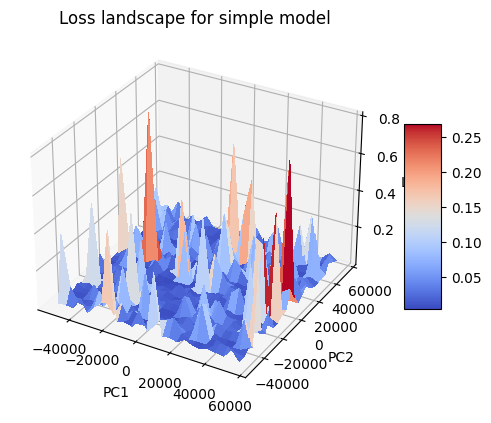

In [13]:
## visualize the loss landscape in 3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, losses, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Loss')
ax.set_title("Loss landscape for simple model")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("figures/loss_landscape_simple.png", dpi=300, bbox_inches='tight')
plt.show()
